In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from mvmm.single_view.gaussian_mixture import GaussianMixture
from mvmm.multi_view.BlockDiagMVMM import BlockDiagMVMM
from mvmm.multi_view.MVMM import MVMM
from mvmm.multi_view.TwoStage import TwoStage
from mvmm.multi_view.MVMMGridSearch import MVMMGridSearch

from mvmm.multi_view.block_diag.toy_data import get_01_block_diag
from mvmm.multi_view.toy_data import sample_gmm, setup_grid_mean_view_params
from mvmm.multi_view.block_diag.graph.bipt_community import community_summary

Text(0, 0.5, 'Second view')

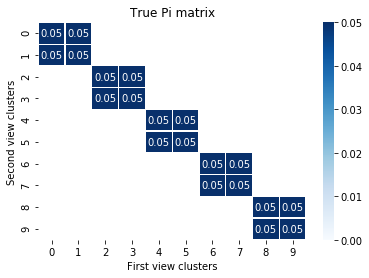

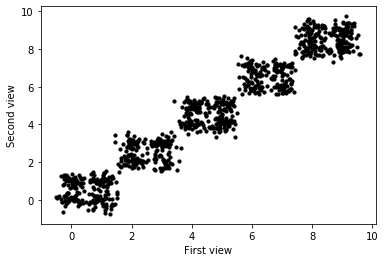

In [2]:
Pi_true = get_01_block_diag(block_shapes=[(2, 2)] * 5)
Pi_true /= Pi_true.sum()

# plot Pi
plt.figure()
sns.heatmap(Pi_true.T,  # transpose so the first view is on the rows
            annot=True, cmap='Blues', vmin=0, linewidths=.2,
            mask=Pi_true.T == 0)
plt.xlabel("First view clusters")
plt.ylabel("Second view clusters")
plt.title("True Pi matrix")

# set up cluster parameters
clust_param_config = {'n_features': [1, 1],
                      # 'clust_mean_std': 10,  # controls how far apart the cluster means are
                      'cluster_std': .25,  # how noisey each cluster is
                      'random_state': 44}

n_view_components = Pi_true.shape
view_params = setup_grid_mean_view_params(n_view_components,
                                          **clust_param_config)

# sample data
view_data, Y_true = sample_gmm(view_params, Pi_true, n_samples=1000, random_state=233)

plt.figure()
plt.scatter(view_data[0], view_data[1], color='black', s=10)
plt.xlabel('First view')
plt.ylabel('Second view')

# Fit block diagonal MVMM for specified number of blocks

In [5]:
base_gmm_params = {'covariance_type': 'diag', 'reg_covar': 1e-6}

base_view_models = [GaussianMixture(n_components=n_view_components[v],
                                    **base_gmm_params) for v in range(2)]



# initialize with a few EM iterations with the MVMM
base_start = MVMM(base_view_models=base_view_models, max_n_steps=10)


base_final = BlockDiagMVMM(n_blocks=5,
                           base_view_models=base_view_models,
                           rel_epsilon=1e-2) # epsilon = rel_epsilon * 1/product(n_view_components), 
                                             # rel_epsilon should be between 0 and 1

    
two_stage = TwoStage(base_start=base_start, base_final=base_final,
                     n_init=1, random_state=883)


two_stage.fit(view_data)

TwoStage(base_final=BlockDiagMVMM(abs_tol=1e-09,
                                  base_view_models=[GaussianMixture(abs_tol=1e-09,
                                                                    covariance_type='diag',
                                                                    history_tracking=0,
                                                                    init_params_method='kmeans',
                                                                    init_params_value=None,
                                                                    init_weights_method='uniform',
                                                                    init_weights_value=None,
                                                                    max_n_steps=200,
                                                                    n_components=10,
                                                                    n_init=1,
                                                           

Text(0.5, 1, 'Estimated D matrix')

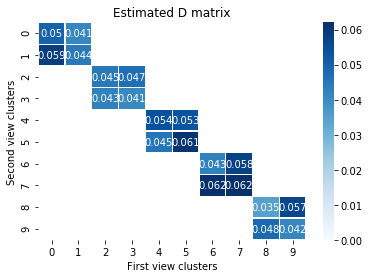

In [6]:
D_est = two_stage.final_.bd_weights_
bd_summary, D_est_bd_perm = community_summary(D_est, zero_thresh=two_stage.final_.zero_thresh)

sns.heatmap(D_est_bd_perm.T,  # transpose so the first view is on the rows
            annot=True, cmap='Blues', vmin=0, linewidths=.2,
            mask=D_est_bd_perm.T == 0)
plt.xlabel("First view clusters")
plt.ylabel("Second view clusters")
plt.title("Estimated D matrix")

# grid search over number of blocks

In [7]:
base_view_models = [GaussianMixture(n_components=n_view_components[v],
                                    **base_gmm_params) for v in range(2)]
base_start = MVMM(base_view_models=base_view_models, max_n_steps=10)
base_final = BlockDiagMVMM(base_view_models=base_view_models)
base_estimator = TwoStage(base_start=base_start, base_final=base_final,
                          n_init=1, random_state=94)

param_grid = {'n_blocks': np.arange(1, 7 + 1)}

grid_search = MVMMGridSearch(base_estimator=base_estimator,
                             param_grid=param_grid,
                             n_jobs=-1)


grid_search.fit(view_data)

print('BIC estimated {} blocks'.format(grid_search.best_params_['n_blocks']))

BIC estimated 5 blocks
